In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import InterpolationMode
import torchvision.transforms.v2 as v2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

class BFSDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, processed_dir=None, resize_factor=2):
        self.images, self.annotations = [], []
        self.processed_dir = processed_dir
        self.resize_factor = resize_factor

        # Check if preprocessed images are available
        if processed_dir and os.path.exists(processed_dir):
            print("Using preprocessed images.")
            self.images = [os.path.join(processed_dir, f) for f in os.listdir(processed_dir) if f.endswith(".jpg")]
            self.annotations = [os.path.join(processed_dir, f) for f in os.listdir(processed_dir) if f.endswith(".png")]
        else:
            print("No preprocessed images found. Using original images.")
            # Load original images and corresponding annotations
            for root, _, files in os.walk(images_dir):
                for file in files:
                    if file.endswith(".jpg"):
                        image_path = os.path.join(root, file)
                        annotation_path = os.path.join(
                            annotations_dir,
                            os.path.relpath(image_path, images_dir).replace(".jpg", ".png")
                        )
                        if os.path.exists(annotation_path):
                            self.images.append(image_path)
                            self.annotations.append(annotation_path)

        # Define the transformation pipeline
        self.transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.uint8, scale=True),
            v2.Resize(
                size=(240 // self.resize_factor, 160 // self.resize_factor),
                interpolation=InterpolationMode.BILINEAR,
                antialias=True
            ),
            v2.ToDtype(torch.float32, scale=True)
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        try:
            # Load and transform image and annotation
            image = Image.open(self.images[idx]).convert("RGB")
            annotation = Image.open(self.annotations[idx]).convert("L")
            
            image = self.transform(image)
            annotation = self.transform(annotation)
            annotation = (annotation > 0.5).float()
            
            return image, annotation
        except Exception as e:
            raise RuntimeError(f"Error loading data at index {idx}: {e}")
        
class UNet(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(UNet, self).__init__()
        # Define the encoder layers
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate),
            nn.MaxPool2d(2)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate),
            nn.MaxPool2d(2)
        )
        # Define the decoder layers
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Forward pass through the network
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        dec1 = self.decoder1(enc2)
        dec2 = self.decoder2(dec1)
        return dec2


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, device="cpu"):
    model.to(device)
    criterion = criterion.to(device)
    train_losses, val_losses = [], []
    train_ious, val_ious = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_total, train_iou_sum = 0.0, 0, 0.0
        
        for images, annotations in train_loader:
            images = images.to(device, non_blocking=True)
            annotations = annotations.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            predictions = model(images)
            loss = criterion(predictions, annotations)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss.item() * images.size(0)
                pred_binary = (predictions > 0.5).float()
                intersection = (pred_binary * annotations).sum().item()
                union = ((pred_binary + annotations) > 0).sum().item()
                train_iou_sum += (intersection / union) * 100 if union > 0 else 0
                train_total += 1
        
        model.eval()
        val_loss, val_total, val_iou_sum = 0.0, 0, 0.0
        
        with torch.no_grad():
            for images, annotations in val_loader:
                images = images.to(device, non_blocking=True)
                annotations = annotations.to(device, non_blocking=True)
                
                predictions = model(images)
                loss = criterion(predictions, annotations)
                
                val_loss += loss.item() * images.size(0)
                pred_binary = (predictions > 0.5).float()
                intersection = (pred_binary * annotations).sum().item()
                union = ((pred_binary + annotations) > 0).sum().item()
                val_iou_sum += (intersection / union) * 100 if union > 0 else 0
                val_total += 1
        
        # Calculate average losses and IoU for the epoch
        train_loss = train_loss / len(train_loader.dataset)
        train_iou = train_iou_sum / train_total
        val_loss = val_loss / len(val_loader.dataset)
        val_iou = val_iou_sum / val_total
        
        # Add scheduler step
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        train_ious.append(train_iou)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train IoU: {train_iou:.2f}%, Val IoU: {val_iou:.2f}%")
    
    # Plot training and validation loss and IoU
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_ious, label="Train IoU (%)")
    plt.plot(val_ious, label="Validation IoU (%)")
    plt.title("IoU Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("IoU (%)")
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

def main():
    images_dir = "Images"
    annotations_dir = "Annotations"
    
    # Determine the device to use for training
    device = (
        "mps" if torch.backends.mps.is_available() 
        else "cuda" if torch.cuda.is_available() 
        else "cpu"
    )
    print(f"Using device: {device}")
    
    # Create dataset and split into training and validation sets
    dataset = BFSDataset(images_dir, annotations_dir)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=16,
        shuffle=True,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=16,
        pin_memory=True
    )
    
    # Initialize the model
    model = UNet(dropout_rate=0.10)  

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=0.01,
        eps=1e-5
    )
    
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.3,
        patience=4,
        min_lr=6e-7,
    )
    
    # Train the model
    train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=400, device=device)

if __name__ == "__main__":
    main()


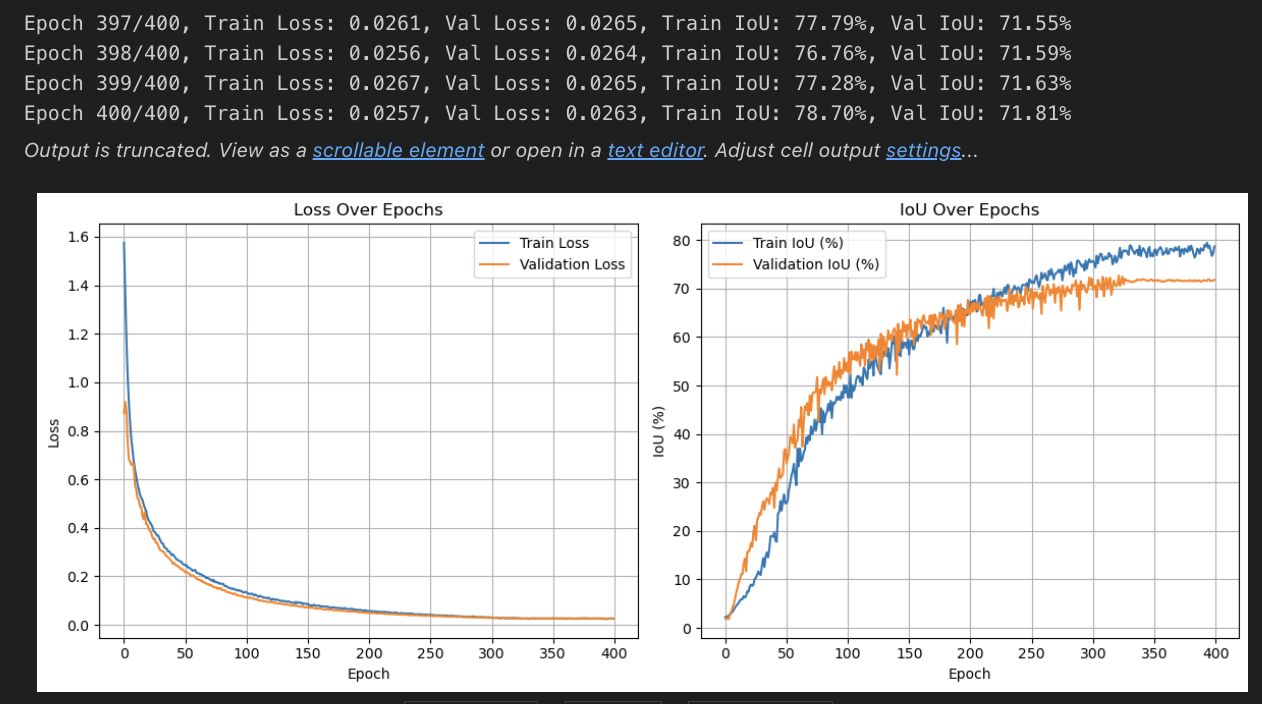

In [45]:
from IPython.display import Image
Image("final model.png")

/var/folders/ll/47w3c9nj0kg5rnll3dcd32jh0000gn/T/ipykernel_80745/1238785234.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

No preprocessed images found. Using original images.


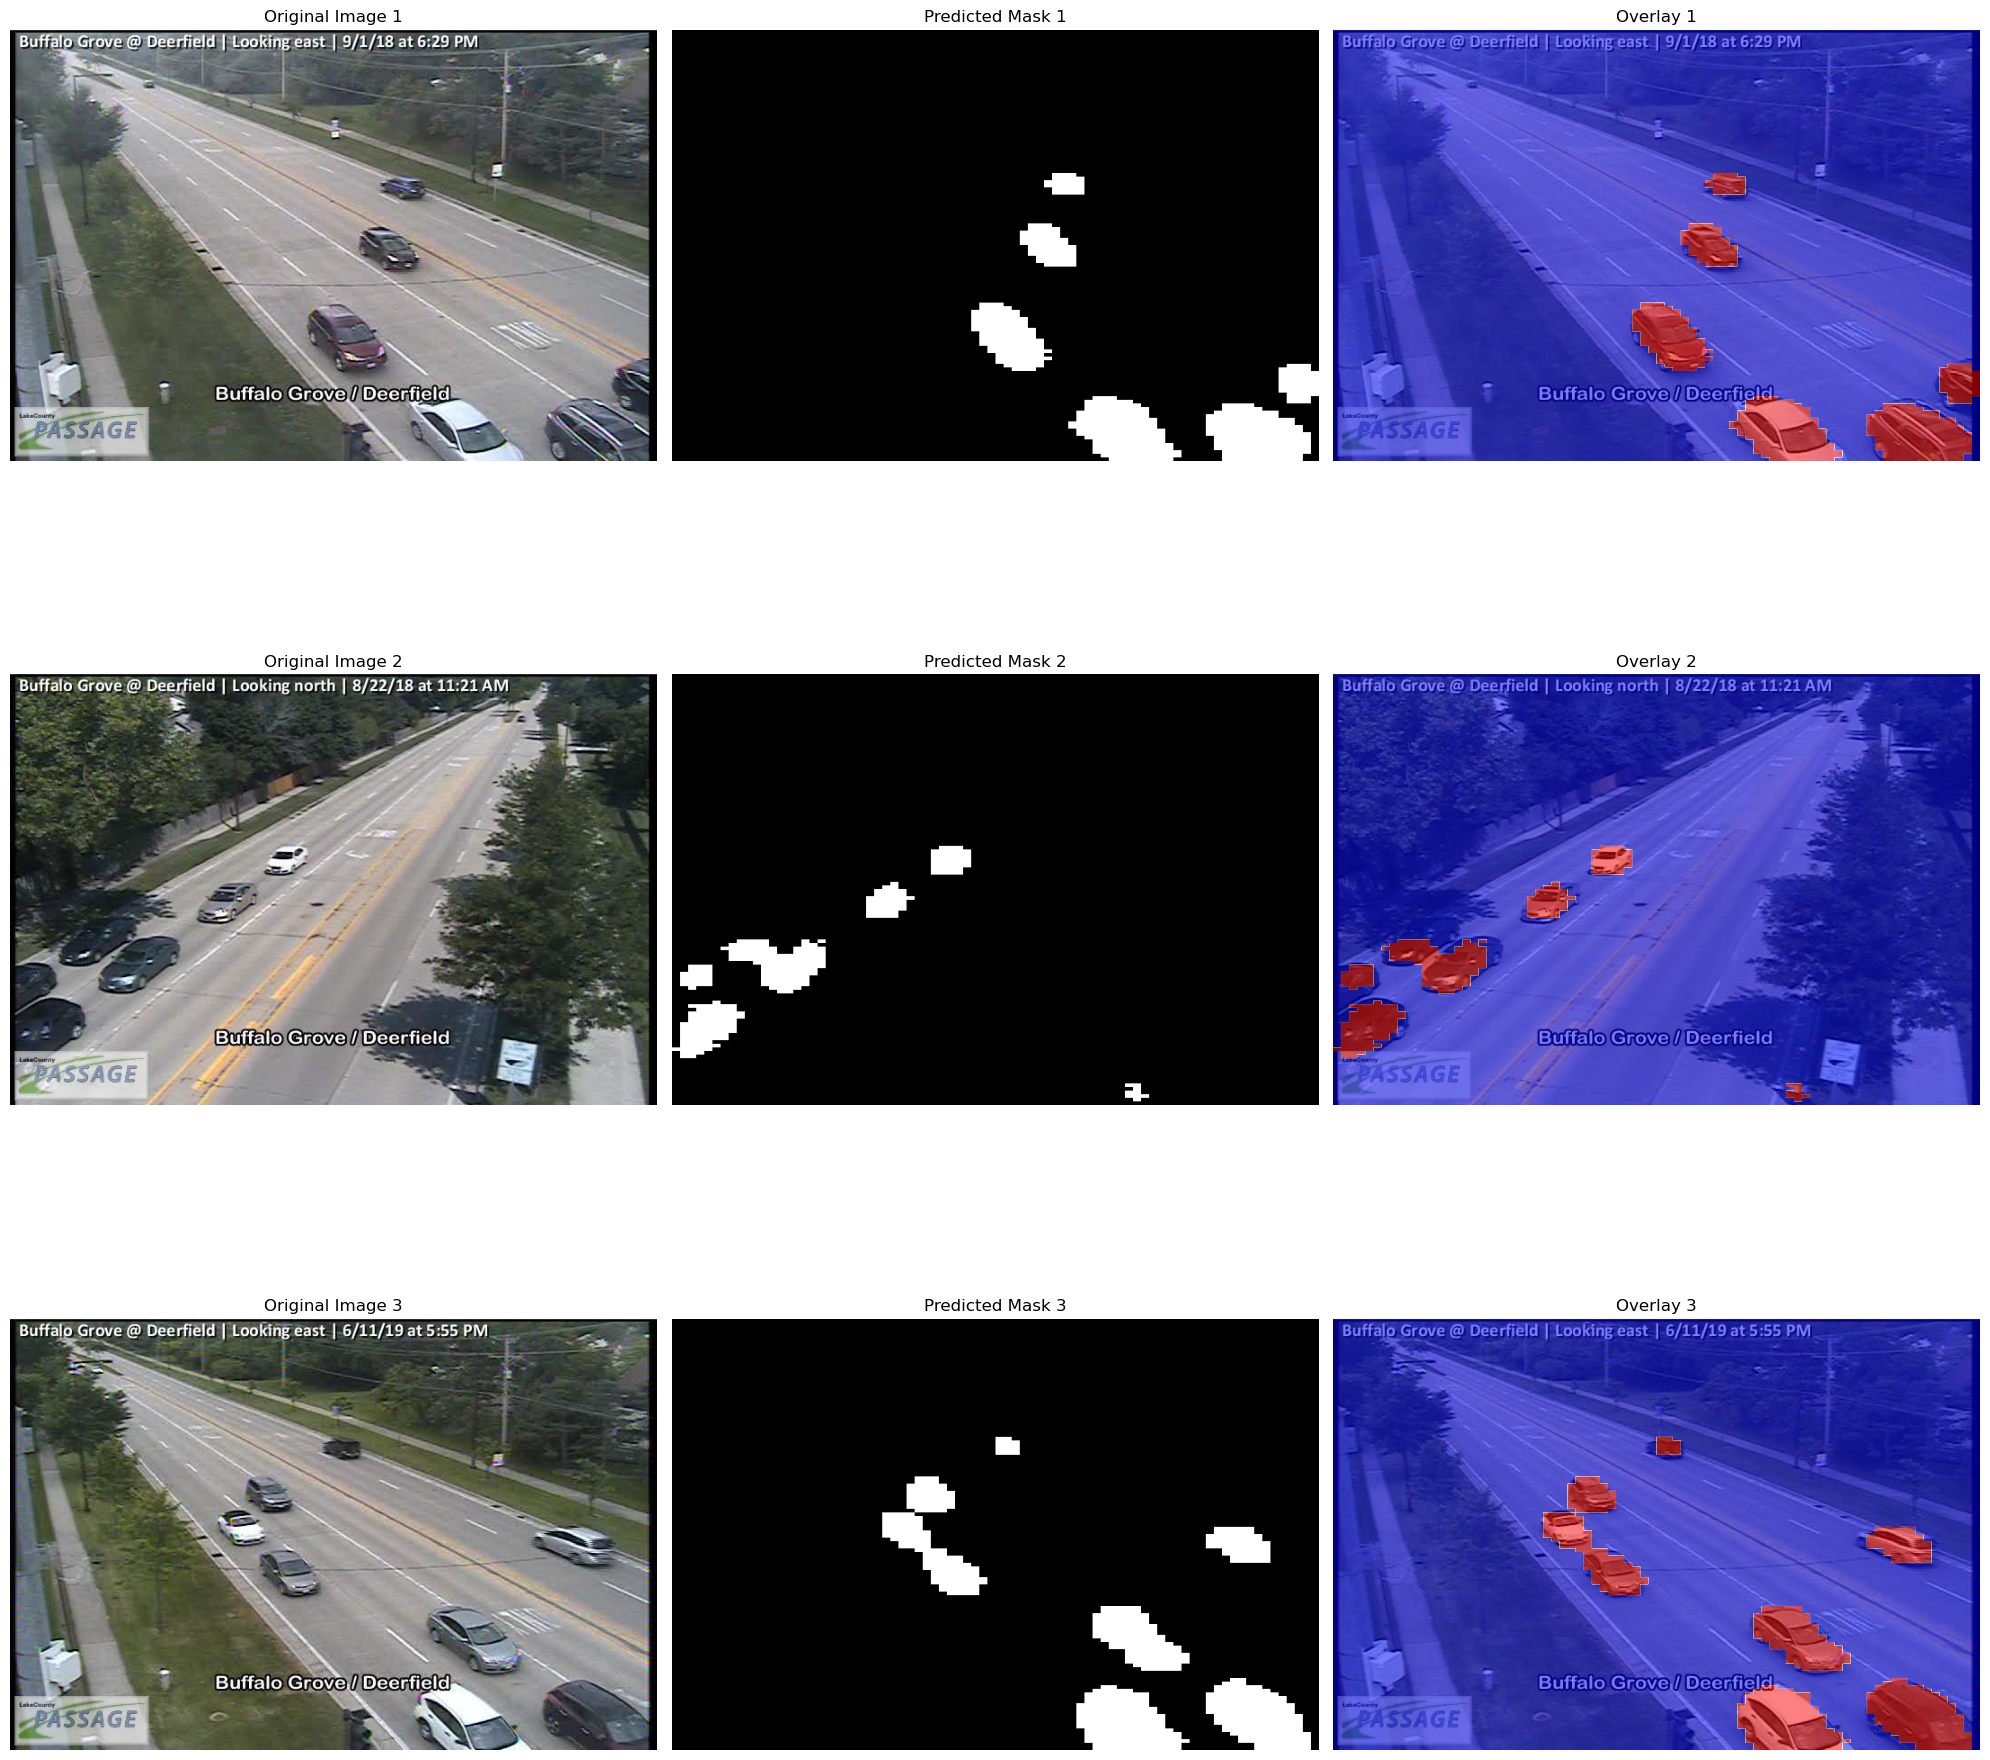

In [35]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import random

def get_random_image_paths(base_dir="Images", num_images=3):
    """Get random image paths from the dataset."""
    scene_dirs = [d for d in os.listdir(base_dir) if "Buffalo Grove at Deerfield" in d]
    image_paths = []
    
    while len(image_paths) < num_images:
        scene = random.choice(scene_dirs)
        scene_path = os.path.join(base_dir, scene)
        date = random.choice(os.listdir(scene_path))
        date_path = os.path.join(scene_path, date)
        image = random.choice([f for f in os.listdir(date_path) if f.endswith('.jpg')])
        image_path = os.path.join(date_path, image)
        
        if image_path not in image_paths:
            image_paths.append(image_path)
    
    return image_paths

def predict_multiple_images(model_path, image_paths, device='cpu'):
    """
    Load a trained model and make predictions on multiple images.
    """
    # Initialize model and load weights
    model = UNet(dropout_rate=0.10)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # Use exact same transform from BFSDataset
    transform = BFSDataset('', '', resize_factor=2).transform
    
    # Create figure
    fig, axes = plt.subplots(len(image_paths), 3, figsize=(20, 7*len(image_paths)))
    
    for idx, image_path in enumerate(image_paths):
        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        original_size = image.size
        
        # Transform and add batch dimension
        transformed_image = transform(image).unsqueeze(0)
        transformed_image = transformed_image.to(device)
        
        # Make prediction
        with torch.no_grad():
            prediction = model(transformed_image)
            mask = (prediction > 0.5).float().cpu().squeeze().numpy()
        
        # Convert original image to numpy array
        image_np = np.array(image)
        
        # Resize mask to match original image size
        mask_resized = np.array(Image.fromarray(mask).resize(
            original_size, 
            Image.Resampling.NEAREST  
        ))
        
        # Original image
        axes[idx, 0].imshow(image_np)
        axes[idx, 0].set_title(f'Original Image {idx+1}', fontsize=12)
        axes[idx, 0].axis('off')
        
        # Predicted mask
        axes[idx, 1].imshow(mask_resized, cmap='gray')
        axes[idx, 1].set_title(f'Predicted Mask {idx+1}', fontsize=12)
        axes[idx, 1].axis('off')
        
        # Overlay
        axes[idx, 2].imshow(image_np)
        overlay = axes[idx, 2].imshow(
            mask_resized, 
            cmap='bwr',  # Back to original colormap
            alpha=0.5
        )
        axes[idx, 2].set_title(f'Overlay {idx+1}', fontsize=12)
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    model_path = 'unet_model.pth'
    image_paths = get_random_image_paths(num_images=3)
    device = (
        "mps" if torch.backends.mps.is_available() 
        else "cuda" if torch.cuda.is_available() 
        else "cpu"
    )
    predict_multiple_images(model_path, image_paths, device)